In [1]:
from pathlib import Path

import jupyter_black
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

# import plotly.express as px
jupyter_black.load()
sns.set()

In [2]:
INPUT_DIR = Path("/home/kuto/kaggle/kaggle-sleep-v2/data/child-mind-institute-detect-sleep-states")
gt_df = pl.read_csv(INPUT_DIR / "train_events.csv")
# gt_df = gt_df.drop_nulls()

Text(0, 0.5, 'label null rate')

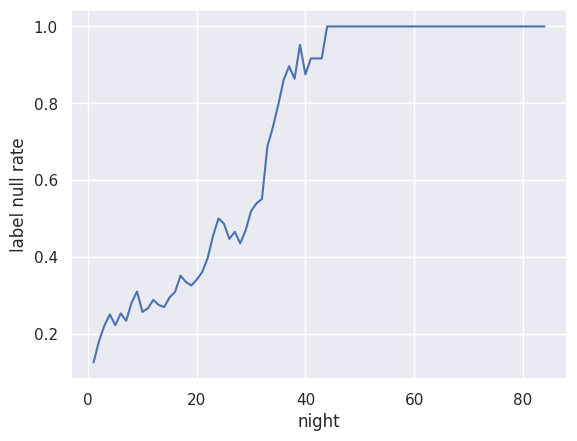

In [23]:
# nightごとのnull数を数える
a = gt_df.group_by("night").agg(pl.col("step").null_count()).sort("night")
b = gt_df.group_by("night").agg(pl.col("step").count()).sort("night")
null_rates = a["step"].to_numpy() / b["step"].to_numpy()
nights = a["night"].to_numpy()
plt.plot(nights, null_rates)
plt.xlabel("night")
plt.ylabel("label null rate")

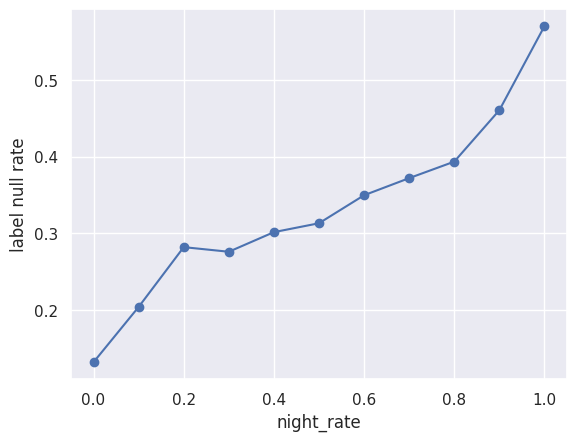

In [41]:
gt_pdf = gt_df.to_pandas()
gt_pdf = gt_pdf.merge(
    gt_pdf.groupby("series_id")["night"].max().rename("max_night"), on="series_id"
)
gt_pdf["night_rate"] = (gt_pdf["night"] / gt_pdf["max_night"]).round(1)
gt_pdf["is_null"] = gt_pdf["step"].isna() * 1
null_count = gt_pdf.groupby("night_rate")["is_null"].sum()
label_count = gt_pdf.groupby("night_rate")["is_null"].count()
null_rate = null_count / label_count
plt.plot(null_rate, marker="o")
plt.xlabel("night_rate")
plt.ylabel("label null rate")
plt.show()

In [38]:
label_count

night_rate
0.0     530
0.1    1352
0.2    1524
0.3    1416
0.4    1392
0.5    1516
0.6    1392
0.7    1416
0.8    1524
0.9    1352
1.0    1094
Name: is_null, dtype: int64

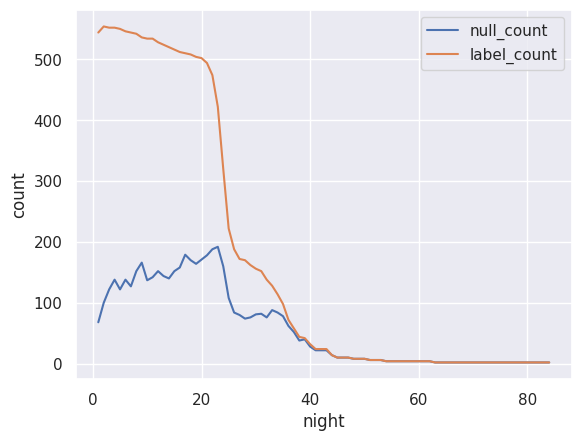

In [26]:
# nightごとのnull数を数える
a = gt_df.group_by("night").agg(pl.col("step").null_count()).sort("night")
b = gt_df.group_by("night").agg(pl.col("step").count()).sort("night")
null_count = a["step"].to_numpy()
label_count = b["step"].to_numpy()
nights = a["night"].to_numpy()
plt.plot(nights, null_count, label="null_count")
plt.plot(nights, label_count, label="label_count")
plt.xlabel("night")
plt.ylabel("count")
plt.legend()

In [3]:
gt_df = gt_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z"),
)

In [4]:
gt_df = gt_df.with_columns(
    pl.col("timestamp").dt.minute().alias("minute"),
    (pl.col("timestamp").dt.minute() % 15).alias("minute_15"),
    (pl.col("timestamp").dt.minute() % 5).alias("minute_5"),
)

/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='minute', ylabel='counts'>

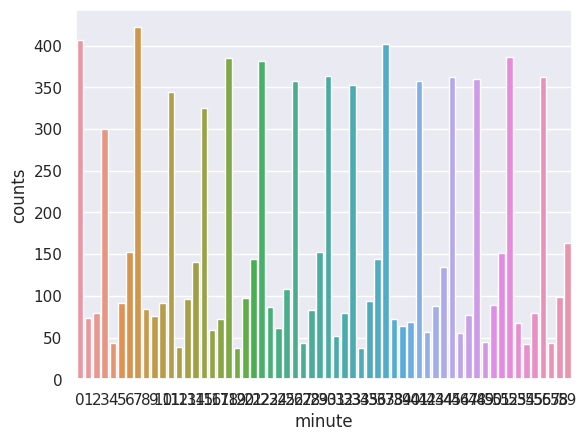

In [5]:
data = gt_df["minute"].value_counts().sort("minute").to_pandas()
sns.barplot(x="minute", y="counts", data=data)

/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='minute_15', ylabel='counts'>

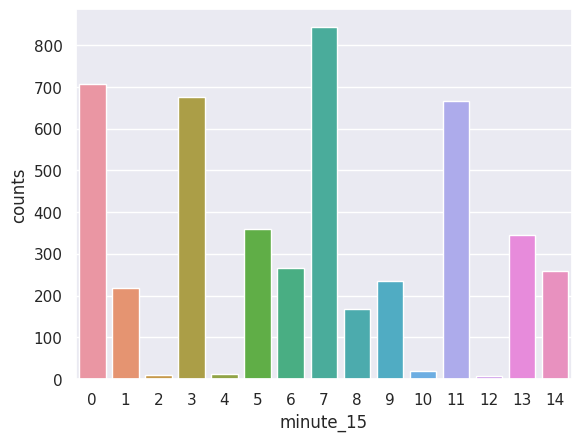

In [6]:
data = (
    gt_df.filter(pl.col("event") == "onset")["minute_15"]
    .value_counts()
    .sort("minute_15")
    .to_pandas()
)
sns.barplot(x="minute_15", y="counts", data=data)

In [7]:
# data = (
#     gt_df.filter(pl.col("event") == "onset")["minute_5"]
#     .value_counts()
#     .sort("minute_5")
#     .to_pandas()
# )
# sns.barplot(x="minute_5", y="counts", data=data)

onsetは0,3,7,11を取る確率が高い。  
そこで二項分布を仮定しseriesごとに正解ラベルが[0,3,7,11]になるか否かの確率を求める

In [8]:
def plot_by_target_minutes_rate(gt_df, event_name="onset", target_minutes=[0, 3, 7, 11]):
    target_minute_counts_by_series = (
        gt_df.filter((pl.col("event") == event_name) & (pl.col("minute_15").is_in(target_minutes)))
        .group_by("series_id")
        .count()
    )

    all_minute_counts_by_series = (
        gt_df.filter((pl.col("event") == event_name)).group_by("series_id").count()
    )
    target_df = all_minute_counts_by_series.join(target_minute_counts_by_series, on="series_id")
    target_df = target_df.with_columns((pl.col("count_right") / pl.col("count")).alias("rate"))
    sns.histplot(target_df["rate"])
    plt.title(f"event={event_name}, target_minutes={target_minutes}")
    plt.show()

/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


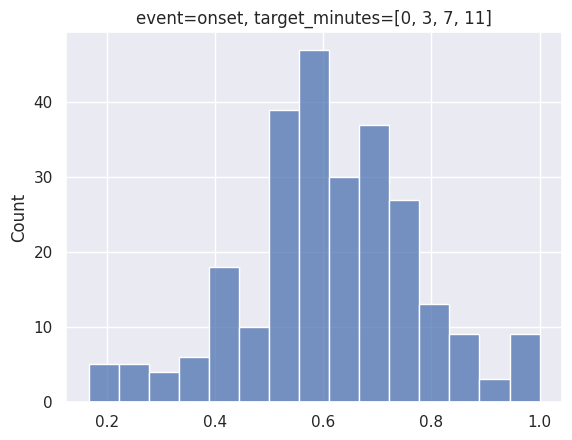

In [9]:
plot_by_target_minutes_rate(gt_df, "onset")

/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kuto/kaggle/kaggle-sleep-v2/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


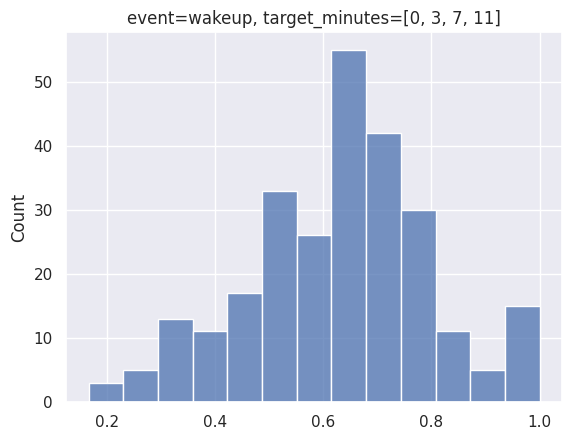

In [10]:
plot_by_target_minutes_rate(gt_df, "wakeup")